In [30]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib 
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [67]:
# Replace 'dataset_url' with the path to your local directory containing images
data_dir = pathlib.Path('Dataset')

# List all subdirectories (classes) within the data directory
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])

# Print the class names
print("Class names:", class_names)


Class names: ['Negative', 'Positive']


In [32]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


40000


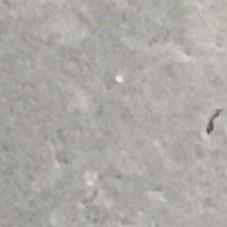

In [33]:
Negatives = list(data_dir.glob('Negative/*'))
PIL.Image.open(str(Negatives[0]))

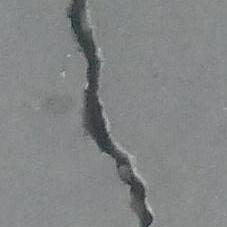

In [34]:
Positive = list(data_dir.glob('Positive/*'))
PIL.Image.open(str(Positive[0]))

# Creating DataSet

In [35]:
batch_size = 32
img_height = 180
img_width = 180

In [36]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.25,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 40000 files belonging to 2 classes.
Using 30000 files for training.


In [37]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.25,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 40000 files belonging to 2 classes.
Using 10000 files for validation.


In [38]:
classes_names = train_ds.class_names
print(classes_names)

['Negative', 'Positive']


# Visualising the Dataset

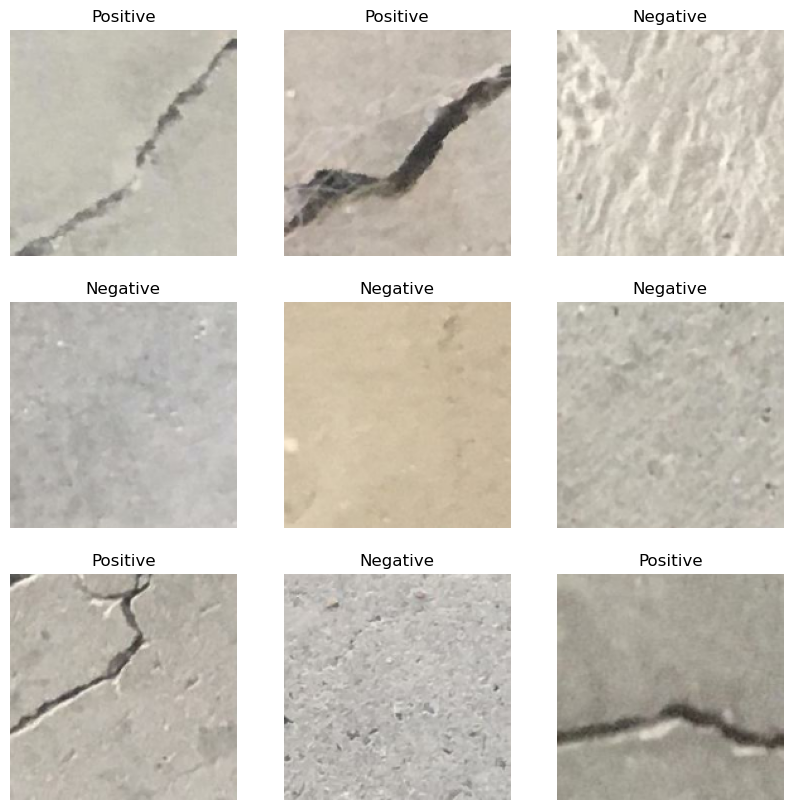

In [39]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes_names[labels[i]])
        plt.axis("off")

In [40]:
for image_batch,labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [42]:
normalization_layer = layers.Rescaling(1./255)

In [43]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.12040724 0.9698662


In [44]:
num_classes = len(classes_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [47]:
epochs = 3
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/3
938/938 [==============================] - 1029s 1s/step - loss: 0.1493 - accuracy: 0.9523 - val_loss: 0.1474 - val_accuracy: 0.9747
Epoch 2/3
938/938 [==============================] - 835s 889ms/step - loss: 0.0548 - accuracy: 0.9856 - val_loss: 0.0462 - val_accuracy: 0.9859
Epoch 3/3
938/938 [==============================] - 605s 645ms/step - loss: 0.0580 - accuracy: 0.9830 - val_loss: 0.0492 - val_accuracy: 0.9877


range(0, 3)


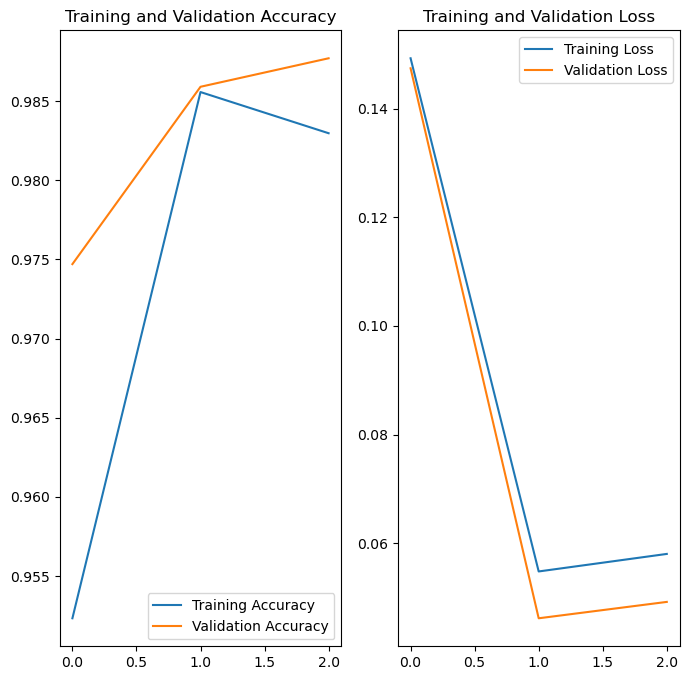

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
print(epochs_range)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [80]:
test_data_path1 = pathlib.Path('Walls//test.jpg')

In [81]:
img = tf.keras.utils.load_img(
    test_data_path1
    , target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 45ms/step
This image most likely belongs to Negative with a 99.80 percent confidence.
